In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch_geometric
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math, copy, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

import fish_models
import numpy as np
import matplotlib.pyplot as plt

from fish_efficientnet import EfficientNetB0

# Build a 2 fish training set

In [2]:
raycast = fish_models.Raycast(
            n_fish_bins=50,
            n_wall_raycasts=50,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [3]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

dset = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:07<00:00, 26.99it/s]


Calculating views from 197 files.


100%|████████████████████████████████████████| 197/197 [01:25<00:00,  2.31it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 21896.86it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 39301.65it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 197/197 [00:00<00:00, 1080.63it/s]


Status of IoDataset:
poses	(197, 8, 749, 3):	consisting of x, y, orientation.
actions	(197, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(197, 8, 749, 150):	consisting of 50 fish bins, 50 fish oris and 50 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


In [5]:
mask2fish = (~np.isnan(dset["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 2
fish2poses = dset["poses"][mask2fish][:,(~np.isnan(dset["poses"][mask2fish]).any(axis=-1).any(axis=-1).any(axis=0))]
fish2actions = dset["actions"][mask2fish][:,(~np.isnan(dset["actions"][mask2fish]).any(axis=-1).any(axis=-1).any(axis=0))]
fish2views = dset["views"][mask2fish][:,(~np.isnan(dset["views"][mask2fish]).any(axis=-1).any(axis=-1).any(axis=0))]
fish2poses.shape, fish2actions.shape, fish2views.shape

((49, 2, 749, 3), (49, 2, 749, 2), (49, 2, 749, 150))

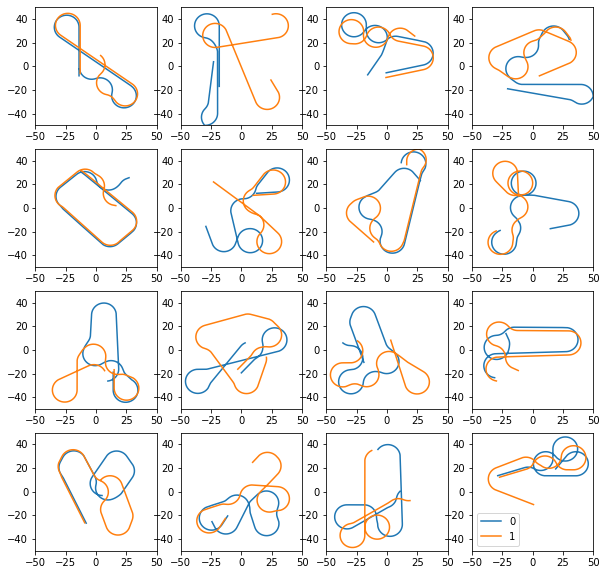

In [7]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
counter = 0
for i in range(4):
    for j in range(4):
        for fish_id in range(2):
            axs[i,j].plot(fish2poses[counter,fish_id, :, 0], fish2poses[counter,fish_id, :, 1], label=fish_id)
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
        counter +=1
plt.legend()
plt.show()

In [8]:
fish2actions.reshape(-1, fish2actions.shape[-1])[:,0].max(), fish2actions.reshape(-1, fish2actions.shape[-1])[:,0].min()

(8.000130206346512, 7.999565452337265)

In [17]:
X_train_reg = fish2views.reshape(-1, fish2views.shape[-1])
y_train_reg = fish2actions.reshape(-1, fish2actions.shape[-1])[:,1]
X_train_reg.shape, y_train_reg.shape

((73402, 150), (73402,))

In [10]:
np.stack((fish2views.reshape(-1, fish2views.shape[-1])[:,:50],
         fish2views.reshape(-1, fish2views.shape[-1])[:,50:100],
         fish2views.reshape(-1, fish2views.shape[-1])[:,100:150]), axis=1).shape

(73402, 3, 50)

In [11]:
X_train_vis = np.stack((fish2views.reshape(-1, fish2views.shape[-1])[:,:50],
                        fish2views.reshape(-1, fish2views.shape[-1])[:,50:100],
                        fish2views.reshape(-1, fish2views.shape[-1])[:,100:150]), axis=1)
y_train_vis = fish2actions.reshape(-1, fish2actions.shape[-1])[:,1]
X_train_vis.shape, y_train_vis.shape

((73402, 3, 50), (73402,))

In [12]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X_train_vis, y_train_vis, test_size=0.2, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

In [13]:
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return (torch.tensor(self.data[index], dtype=torch.float), torch.tensor(self.label[index], dtype=torch.float))

    def __len__(self):
        return len(self.data)

In [14]:
# class_sample_count = np.array(
#     [len(np.where(y_train == t)[0]) for t in np.arange(MAX_VAL2)])
# weight = 1. / (class_sample_count + 0.0001)
# samples_weight = np.array([weight[t] for t in y_train])
# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

BATCH_SIZE = 256

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
val_dataset = MyDataset(X_val, y_val)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)#, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Train Model

In [15]:
# from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [18]:
regr = RandomForestRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_reg, y_train_reg)
# R^2 value between 0 (always predict expected value) and 1 (always true prediction)
regr.score(X_train_reg, y_train_reg)

0.9956363126997839

In [19]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, scheduler, val_loss, epoch):
    if save_path==None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler_state_dict': scheduler.state_dict(),
                  'val_loss': val_loss,
                  'epoch': epoch}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(save_path, model, optimizer, scheduler):
    if save_path==None:
        return
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    scheduler.load_state_dict(state_dict['scheduler_state_dict'])
    val_loss = state_dict['val_loss']
    epoch = state_dict['epoch']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss, epoch

In [20]:
def train_with_scheduler(model, optimizer, scheduler, train_loader, val_loader, save_path, criterion, epochs=10, best_val_loss=float("Inf")):

    failed_counter = 0
    train_losses = []
    val_losses = []
    log = 50
    avg_val_loss = 0.0
    t0 = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            input_x, input_y = tuple(t.to(device) for t in batch)
            pred = model(input_x)
            loss = criterion(pred, input_y.reshape((-1,1)))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 100 == 0:
                print(f"Epoch number: {epoch+1}/{epochs}, Sample: {batch_idx}/{len(train_loader)}", end="\r")
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        #check validation loss after every epoch
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for batch_idx, batch in enumerate(val_loader):
                input_x, input_y = tuple(t.to(device) for t in batch)
                pred = model(input_x)
                loss = criterion(pred, input_y.reshape((-1,1)))
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        seconds = time.time() - t0
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        for g in optimizer.param_groups:
            new_lr = g['lr']
            break
        print(f"[Epoch: {epoch+1}/{epochs}][LR: {new_lr:.6f}][Train Loss: {avg_train_loss:.4f}][Val Loss: {avg_val_loss:.4f}][Time: {h:.0f}:{m:.0f}:{s:.0f}]")
        
        model.train()
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_path, model, optimizer, scheduler, best_val_loss, epoch)
            failed_counter = 0
        else:
            if failed_counter == 10:
                print("Early Stopping!")
                break
            failed_counter += 1
    return train_losses, val_losses

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

effNetModel = EfficientNetB0(1)

save_path = 'EfficientNetB0_fish_weights.pth'
effNetModel.to(device)
optimizer = optim.Adam(effNetModel.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001)
#----------------------- ADD -------------------------------------------
#best_val_loss, epoch = load_checkpoint(save_path, effNetModel, optimizer, scheduler)
#-----------------------------------------------------------------------
effNetModel.eval()
summary(effNetModel, (BATCH_SIZE, 3, 50))

Layer (type:depth-idx)                   Output Shape              Param #
EfficientNet                             --                        --
├─Conv1d: 1-1                            [256, 32, 50]             288
├─BatchNorm1d: 1-2                       [256, 32, 50]             64
├─Sequential: 1-3                        [256, 320, 4]             --
│    └─Block: 2-1                        [256, 16, 50]             --
│    │    └─Conv1d: 3-1                  [256, 32, 50]             96
│    │    └─BatchNorm1d: 3-2             [256, 32, 50]             64
│    │    └─SE: 3-3                      [256, 32, 50]             552
│    │    └─Conv1d: 3-4                  [256, 16, 50]             512
│    │    └─BatchNorm1d: 3-5             [256, 16, 50]             32
│    └─Block: 2-2                        [256, 24, 25]             --
│    │    └─Conv1d: 3-6                  [256, 96, 50]             1,536
│    │    └─BatchNorm1d: 3-7             [256, 96, 50]             192
│    │  

In [22]:
num_epochs = 200
criterion = nn.MSELoss()
train_losses, val_losses = train_with_scheduler(effNetModel, optimizer, scheduler, train_dataloader, 
                                                val_dataloader, save_path, criterion, num_epochs)#, best_val_loss=2.1824)

[Epoch: 1/200][LR: 0.001000][Train Loss: 0.3650][Val Loss: 0.1689][Time: 0:0:39]
Model saved to ==> EfficientNetB0_fish_weights.pth
[Epoch: 2/200][LR: 0.001000][Train Loss: 0.1747][Val Loss: 0.1430][Time: 0:1:17]
Model saved to ==> EfficientNetB0_fish_weights.pth
[Epoch: 3/200][LR: 0.001000][Train Loss: 0.1401][Val Loss: 0.1400][Time: 0:1:55]
Model saved to ==> EfficientNetB0_fish_weights.pth
[Epoch: 4/200][LR: 0.001000][Train Loss: 0.1258][Val Loss: 0.1420][Time: 0:2:33]
[Epoch: 5/200][LR: 0.001000][Train Loss: 0.1190][Val Loss: 0.1254][Time: 0:3:12]
Model saved to ==> EfficientNetB0_fish_weights.pth
[Epoch: 6/200][LR: 0.001000][Train Loss: 0.1151][Val Loss: 0.1163][Time: 0:3:51]
Model saved to ==> EfficientNetB0_fish_weights.pth
[Epoch: 7/200][LR: 0.001000][Train Loss: 0.1008][Val Loss: 0.1152][Time: 0:4:30]
Model saved to ==> EfficientNetB0_fish_weights.pth
[Epoch: 8/200][LR: 0.001000][Train Loss: 0.0834][Val Loss: 0.1253][Time: 0:5:9]
[Epoch: 9/200][LR: 0.001000][Train Loss: 0.0711

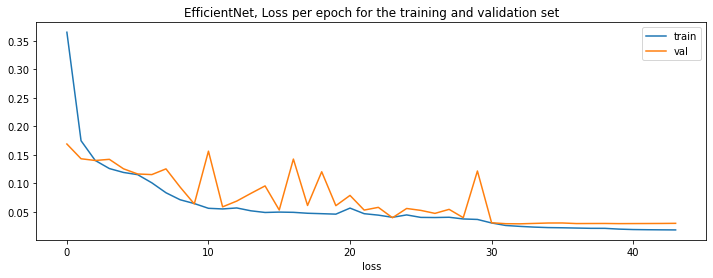

In [23]:
plt.figure(figsize=(12,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("epoch")
plt.xlabel("loss")
plt.title("EfficientNet, Loss per epoch for the training and validation set")
plt.show()

# Model Eval

In [24]:
effNetModel = EfficientNetB0(1)

save_path = 'EfficientNetB0_fish_weights.pth'
effNetModel.to(device)
optimizer = optim.Adam(effNetModel.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001)
#----------------------- ADD -------------------------------------------
best_val_loss, epoch = load_checkpoint(save_path, effNetModel, optimizer, scheduler)
#-----------------------------------------------------------------------
effNetModel.eval()
best_val_loss, epoch

Model loaded from <== EfficientNetB0_fish_weights.pth


(0.028856728707665, 32)

In [25]:
def model_eval(model, dataloader):
    with torch.no_grad():
        model.eval()
        all_pred_prob = []
        labels = []
        for batch_idx, batch in enumerate(dataloader):
            input_x, input_y = tuple(t.to(device) for t in batch)
            pred = model(input_x)
            all_pred_prob.append(pred.cpu().data.numpy())
            labels.append(input_y.cpu().data.numpy())
        all_pred_prob = np.concatenate(all_pred_prob)
        labels = np.concatenate(labels)
        return all_pred_prob, labels

In [26]:
test_pred, test_lbls =  model_eval(effNetModel, test_dataloader)

In [27]:
np.power(test_pred - test_lbls,2).mean()

0.8424065

In [28]:
np.abs(test_pred - test_lbls).mean()

0.7148146

# Visualize Predictions

Extras:

fish_models.raw_data("live_female_female") / "train"
fish_models.raw_data("couzin_torus") / "train"
f = gen.as_io_file(track, save_path=tmpdirname + f"/track_{i}_{j}.hdf5")
f.plot()
f.plot(lw_distances=True)

In [29]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, raycast, regressor):
        self.raycast = raycast
        self.regressor = regressor

    def choose_action(self, view):
        speed = 8
        x_input = np.stack((view.reshape(-1, view.shape[-1])[:,:50],
                            view.reshape(-1, view.shape[-1])[:,50:100],
                            view.reshape(-1, view.shape[-1])[:,100:150]), axis=1)
        x_input = torch.tensor(x_input, dtype=torch.float)
        turn = self.regressor(x_input).detach().numpy().item()
        return speed, turn

100%|████████████████████████████████████████| 999/999 [00:44<00:00, 22.35it/s]


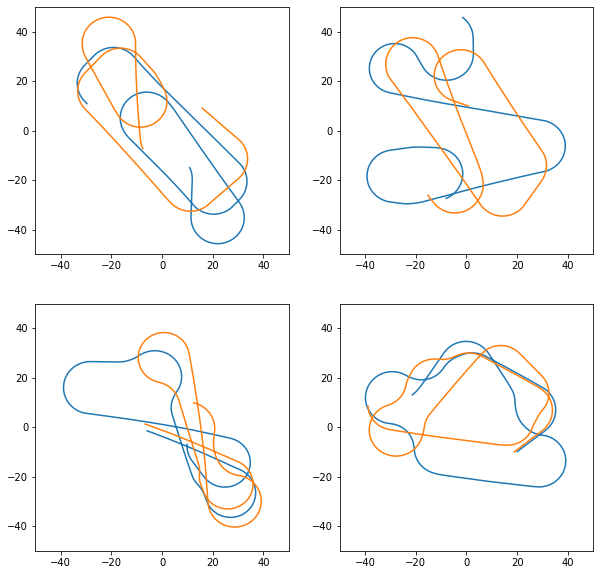

In [30]:
with torch.no_grad():
    effNetModel.eval()
    effNetModel.to("cpu")
    raymodel = CouzinModel(raycast, effNetModel)

    generator = fish_models.TrackGeneratorGym(
        [raymodel], world_size=[100,100], frequency=25
)
n = 2
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        track = generator.create_track(n_guppies=n, trackset_len=1000)
        for fish_id in range(n):
            axs[i,j].plot(track[fish_id, :, 0], track[fish_id, :, 1], label=fish_id)
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
plt.show()